# Трансформация датасетов: добавление новых колонок и расширенный анализ данных
В этом ноутбуке датафреймы дополняются новыми колонками, которые могут характеризовать успешность проекта, и производится вторичный анализ данных проекта.

**Содержание**
1. [Поиск идей по вторичным данным](#intermid_analysis)
2. [Загружаем библиотеки](#libs)
3. [Загружаем данные](#load_data)
4. [Преобразование и анализ остовного датафрейма с протоколами](#protocols_dataframe_transformation)
5. [Преобразование и анализ датафрейма с организациями](#organizations_dataframe_transformation)
6. [Преобразование и анализ датафрейма с учителями](#teachers_dataframe_transformation)




___
<a id='intermid_analysis' name='intermid_analysis'></a>
## 1. Поиск идей по вторичным данным

#### Вторичные колонки на основе анализа времени проведения урока
- В рамках нашего проекта четко выделяются два периода — весна и осень 2022 года. Очевидно, что будет полезно  добавить колонку для указания периода, в который попадает протокол (весна - 1, осень - 2).
- Поле с датой кажется более интересным заменить полем, в котором будет храниться информация о том, сколько дней прошло с начала периода. Условно этой стартовой датой могут быть даты первого урока весны и первого урока осени соответственно.
- Для более наглядной статистики можно добавить еще одно поле, где фиксировать количество недель, прошедших с недели, когда был заполнен первый протокол текущего периода.
- **Интересный параметр** - это информация о том, сколько дней прошло с момента заполнения учителем предыдущего протокола. Для первого протокола периода (весны или осени) этот параметр может быть определен как NaN, а для всех остальных протоколов - как разница дней между текущим и предыдущим протоколами. Этот параметр позволит фиксировать ситуации, когда протоколы заполняются учителем с сильно меняющимися дельтами. Это может говорить о формальном отношении учителя или даже всей школы к проекту. Можно для сводной статистики по отдельному учителю на основании этих параметров фиксировать как среднее время интервалов между уроками, так и дисперсию этого параметра. В идеале дисперсия должна быть минимальной, по дисперсиям можно будет сравнивать и учителей, и организации.


#### Анализ данных из протоколов с информацией о группах учеников (сильные, средние, слабые)
В **усложненных** и **прицельных** протоколах, которые использовались в школах, присутствуют вопросы, которые позволяют оценивать как среднюю успешность учеников каждого класса, так и то, как распределяется внимание учителя при работе с каждой из групп. Важно отметить, что оценки уровня успешности каждого ученика весьма субъективны, и разные учителя, возможно, один и тот же класс оценивали бы по-разному. НО в контексте этого проекта точность оценок силы ученика не столь важна. Важно то, что один и тот же учитель не только оценивает уровень успешности ученика, но и фиксирует реальное количество взаимодействий с ним. Это позволяет построить систему оценки уровня распределения внимания учителя между учениками разных уровней успешности, основывающуюся не на абсолютных значениях, а на относительных.

Исходя из задач обучения мы считаем, что учитель изменил к лучшему качество своих уроков, если:
- большее количество учеников стали оказываться в зоне его внимания
- если распределение внимания учителя либо равномерное по ученикам разного уровня успешности, либо сместилось в сторону поддержки более слабых учеников.

Второй критерий не всегда может говорить о том, что школы, сместившие вектор внимания на сильных учеников, не правы - могут быть классы, в которых дети в целом успешны, и учитель вкладывает больше усилий в тех учеников, которые могут помочь школе повысить свой рейтинг благодаря успехам в олимпиадах и других мероприятиях, учитывающихся при подсчете рейтинга. Однако договоримся о том, что описанные выше критерии мы будем считать индикаторами успешного обучения, приведшего к изменениям в поведении учителя.

Предлагается использовать следующий подход к формированию метрик, которые позволят зафиксировать эти критерии.

В протоколах есть вопросы, часть из которых фиксирует количество **взаимодействий** с учениками, а есть вопросы, которые фиксируют **количество учеников**, с которыми учитель на уроке взаимодействовал. Первый тип вопросов сложно анализировать, потому что количество взаимодействий может зависеть от особенностей урока, выбранной формы работы учителя с учениками. На одном уроке взаимодействий может быть мало, и это нормально, а на другом - много, и это тоже нормально. Поэтому для формирования первого критерия мы будем анализировать соотношение между количеством учеников, которые присутствовали на урокен, и учениками, с которыми учитель взаимодействовал (независимо от их уровня). Будет хорошо, если осенью этот параметр для учителя оказался более высоким, чем весной. 

Таким образом, добавим в датасет с протоколами колонку - процент учеников в зоне внимания от общего количества присутствующих на уроке.

Для того, чтобы посчитать второй параметр, создадим промежуточные колонки для каждого из вопросов, который фиксировал параметры учеников с разными уровнями успеваемости. Эти колонки будут фиксировать среднюю успеваемость учеников класса и дисперсию успеваемости, фактически определяющую, насколько близка или отличается успеваемость учеников одного класса.

Рассмотрим эти дополнительные колонки и правила их подсчета для колонок, содержащих информацию о том, сколько сильных, средних и слабых учеников присутствовало на уроке. Аналогичным образом будут создаваться дополнительные колонки и для вопросов о количестве взаимодействий с учениками разных уровней, и для вопросов о количестве учеников разного уровня, с которыми взаимодействовал учитель. 

Итак, предположим, что на уроке было $Y_{1}$ сильных учеников, $Y_{2}$ средних учеников и $Y_{3}$ слабых учеников.  

Общее количество учеников в классе $Y = Y_{1} + Y_{2} + Y_{3}$.  

Будем считать среднюю успеваемость по формуле ([markdown formulas](https://medium.com/analytics-vidhya/writing-math-equations-in-jupyter-notebook-a-naive-introduction-a5ce87b9a214))

$${M} = \frac{Y_{1} + Y_{2}0.5 + Y_{3}}{Y}$$


Эта формула в своих крайних значениях даст следующие результаты:
- Если все ученики в классе сильные, М = 1. 
- Если все ученики - слабые, М = 0 
- Если все ученики средние - М = 0.5. 
- Если в классе половина сильных и половина слабых учеников, М = 0.5

Параметр, который будем считать дисперсией, будем вычислять по формуле:  
$$ D= \sqrt{\frac{Y_{1}(M-1)^2 + Y_{2}(M-0.5)^2 + Y_{3}(M-0)^2}{Y}}  $$

- Если все ученики в классе сильные, средние или слабые, $D=0$. 
- Если в классе поровну сильных, средних и слабых, $M=0.5$, а $D\approx 0.42$
- Если в классе половина учеников - сильная, а половина - слабая, $M=0.5$, а $D=0.5$
- Если в классе половина сильных и половина средних учеников, $M=0.75$, а $D=0.25$


Благодаря тому, что у нас появляется пара этих параметров, мы получаем возможность сравнивать распределение присутствующих на уроке учеников по успеваемости с распределением количества взаимодействий учителяс учениками разной успеваемости и с распределением количества учеников разного уровня, с которыми учитель взаимодействовал.

Важно при этом отметить, что можно ожидать стопроцентного охвата всех учеников в малокомплектных школах. Если на уроке присутствует всего 4-5 учеников, учитель почти наверняка успеет пообщаться с каждым из них.

Предположим, мы анализируем параметры конкретного протокола, в котором зафиксирована следующая информация:
- Количество учеников на уроке: сильные - 4, средние - 6, слабые - 8 ($M_{1.1}=0.39$, $D_{1.1}=0.39$)
- Количество взаимодействий на уроке: сильные - 5, средние - 8, слабые - 7 ($M_{1.2}=0.45$, $D_{1.2}=0.38$)
- Количество учеников, с которыми взаимодействовал учитель: сильные - 2, средние - 3, слабые - 6 ($M_{1.3}=0.31$, $D_{1.3}=0.38$)

Также предположим, что следующий протокол этого же учителя имел следующие параметры:
- Количество учеников на уроке: сильные - 3, средние - 8, слабые - 5 ($M_{2.1}=0.44$, $D_{2.1}=0.35$)
- Количество взаимодействий на уроке: сильные - 5, средние - 8, слабые - 3 ($M_{2.2}=0.56$, $D_{2.2}=0.35$)
- Количество учеников, с которыми взаимодействовал учитель: сильные - 2, средние - 6, слабые - 5 ($M_{2.3}=0.38$, $D_{2.3}=0.35$)

Как мы можем сравнить эти протоколы? Количество учеников в классах разное, распределение учеников по уровню - тоже разное.
Однако благодаря матожиданию мы видим, что на первом уроке - более слабый класс (0.39 < 0.44), при этом, сравнивая дисперсии, мы видим, что распределение учеников в классе по уровням на этих уроках похоже.

Что мы можем сказать о том, насколько равномерно распределялось внимание учителя между учениками разных уровней на первом уроке? Сравним параметры $M_{1.1}$ и $M_{1.3}$ для первого урока. Мы видим, $M_{1.1}=0.39$, $M_{1.3}=0.31$, т.е. $M_{1.1}>M_{1.3}$
Получается, что при существующем распределении учеников на уроке учитель чуть больше внимания уделял более слабым ученикам, чем более сильным, т.е. с точки зрения "хорошего" урока это - положительный результат!

Аналогично получаем для второго урока, что $M_{2.1}>M_{2.3}$

Если мы сравним также пары $M_{1.1}$ и $M_{1.2}$, а также $M_{2.1}$ и $M_{2.2}$, то тут ситуация - обратная. В обоих случаях учитель хотя и обратил внимание на бОльшее количество слабых учеников, общался во время урока больше с сильными учениками.

Рассмотрев эти примеры, мы можем увидеть, что для каждого протокола будет рациональным добавить три дополнительных параметра, каждый из которых будет показывать, куда направлен на уроке условный "вектор внимания" учителя. Это - дельты между $M_{1}$, $M_{2}$ и $M_{3}$

Добавим и эти колонки в датасет:
- $V_{1} = M_{1} - M_{2}$ - Назовем этот параметр Вектор взаимодействия. Если этот параметр больше нуля, то это означает, что учитель во время урока взаимодействовал с бОльшим количеством более слабых учеников. 
- $V_{2} = M_{1} - M_{3}$ - Назовем этот параметр Вектор намерения. Если этот параметр больше нуля, то это означает. что у учителя во время урока было больше взаимодействий с более слабыми учениками.
- $V_{3} = M_{2} - M_{3}$ - Назовем этот параметр Вектор внимания. Если этот параметр близок к нулю, можно считать, что учитель не только поставил задачу охватить во время урока своим вниманием определенные группы учеников, но и в течение всего урока сохранял пропорцию распределения своего внимания с учениками каждой из групп. Можно предположить, что если учитель на урок поставил себе задачу больше взаимодействовать с одной группой учеников, но подсознательно он более склонен к работе с другой группой, то из-за потери внимания во время урока он может неосознанно иногда смещать вектор своего внимания в сторону более комфортного для себя взаимодействия. Это - гипотеза, посмотрим, проявится ли это как-то на конкретных данных.


Как использовать параметр $D$, пока не очень понятно, но кажется полезным как минимум учитывать этот параметр как одну из характеристик распределения учеников разных уровней для присутствующих на уроке. Может быть, дальнейший анализ данных проекта позволит увидеть дополнительную ценность этого параметра. Тем не менее кажется очевидным, что чем ближе это параметр к нулю, тем менее надежными оказываются выше описанные методы измерения дельт между матожиданиями. Условно - если в классе присутствуют ученики, имеющие одинаковый уровень успеваемости, то кого бы и сколько бы учитель во время не спрашивал, $V_{i}$ будут стремиться к нулю. Для малокомплектных классов эта ситация может быть актуальной.


Указанные выше параметры могут считаться для каждого протокола.

Однако если готовить сводную статистику по каждому учителю, такие обобщенные параметры по всем протоколам можно считать не как среднее арифметическое этих параметров для всех протоколов учителя, а суммировать количества сильных, средних. слабых учеников по всем протоколам анализируемого периода (весны и осени) и вычислять матожидания и дисперсии относительно этих сумм. Это позволит получить более правдоподобные цифры в случае малокомплектных школ.

Аналогичный подход может быть использован и при вычислении этих обобщенных параметров на уровне школы. Могут быть проанализированы протоколы всех учителей этой школы и выведены средние значения этих параметров для школы как для весны, так и для осени.

Если для организации указанные параметры вычислены, появляется возможность сравнивать показатели каждого учителя со средними показателями по школе. Это позволит выявлять учителей, параметры которых отличаются от параметров его коллег.



#### Идеи на будущее (открытый список, который можно расширять по мере выполнения этого проекта)
- Теоретически можно также анализировать информацию о повторных использованиях одних и тех же протоколов. В частности интересно было бы "поймать" корреляцию между повторными обращениями к протоколу и ответам учителя на вопросы об удовлетворенности уроком и желании что-то изменить для более ранних уроков, на которых использовался повторяющийся протокол. Эту идею пока фиксирую скорее на будущее.


Ссылка для себя: ([markdown formulas](https://medium.com/analytics-vidhya/writing-math-equations-in-jupyter-notebook-a-naive-introduction-a5ce87b9a214))

In [1]:
# Вычисление M, D (Функция использовалась для вычисления примеров значений в предыдущей ячейке)
def calc_MD(pupils=[0,0,0]):
    M, D = 0, 0
    Y1, Y2, Y3 = pupils
    Y = Y1 + Y2 + Y3
    if (Y>0):
        M = (Y1 + Y2*0.5)/Y
        D = ((Y1*(M-1)**2 + Y2*(M-0.5)**2 + Y3*M**2)/Y)**0.5
    return M, D    

calc_MD([2,6,5])

(0.38461538461538464, 0.34828404377451605)

___
<a id='libs' name='libs'></a>
## 2. Загружаем библиотеки для работы с данными


In [2]:
%run "./lib/load_big_libs.py"

In [3]:
%run "./lib/data_lib.py"

___
<a id='load_data' name='load_data'></a>
## 3. Загружаем базовые датафреймы
*Функция get_core_dataframes загружена из файла /lib/data_lib.py*

In [4]:
df_templates, df_protocols = get_core_dataframes('gap')

# Сразу же проверяем данные о шаблонах
df_templates.head(20)

,code,id,title,group,level,protocols_df_name
0,П1.1,1,Базовый протокол «Распределение внимания учителя»,Распределение внимания учителя,1,protocols_1_1
1,П1.2,3,Усложненный протокол «Распределение внимания у...,Распределение внимания учителя,2,protocols_1_2
2,П1.3,2,Прицельный протокол «Распределение внимания уч...,Распределение внимания учителя,3,protocols_1_3
3,П2.1,4,Базовый протокол «Время на размышление»,Время на размышление,1,protocols_2_1
4,П2.2,6,Усложненный протокол «Время на размышление»,Время на размышление,2,protocols_2_2
5,П2.3,5,Прицельный протокол «Время на размышление»,Время на размышление,3,protocols_2_3
6,П3.1,7,Базовый протокол «Тип вопросов»,Тип вопросов,1,protocols_3_1
7,П3.2,9,Усложненный протокол «Тип вопросов»,Тип вопросов,2,protocols_3_2
8,П3.3,8,Прицельный протокол «Тип вопросов»,Тип вопросов,3,protocols_3_3
9,П4.1,10,Базовый протокол «Качество обратной связи»,Качество обратной связи,1,protocols_4_1


___
<a id='protocols_dataframe_transformation' name='protocols_dataframe_transformation'></a>
## 4. Дополним основной датасет с протоколами дополнительными колонками

#### По времени
1. Добавим колонку **period** (1 - весна, 2 - осень)  
2. Добавим колонку **day** (порядковый номер дня с даты первого урока, зафиксированного в системе)
3. Добавим колонку **day_of_period** (порядковый номер дня с даты первого урока, зафиксированного в системе для текущего периода - весна или осень)
4. Добавим колонку **interval** (nan для первого протокола учителя в текущем периоде или разница в днях текущего протокола и предыдущего)

#### По группам учеников 
1. Добавим колонку **scope** (отношение количества учеников, с которыми взаимодействовал учитель, к общему количеству учеников на уроке. nan если поля pupils_all или attention_all нулевые или равны nan, и attention_all/pupils_all в противном случае)
2. Добавим колонку **pupils_m** (матожидание среднего уровня учеников на уроке. Число от 0 до 1)
3. Добавим колонку **pupils_d** (дисперсия уровня учеников на уроке. Число от 0 до 1)
4. Добавим колонку **interactions_m**
5. Добавим колонку **interactions_d**
6. Добавим колонку **attention_m**
7. Добавим колонку **attention_d**
8. Добавим колонку **vector_interact** (Вектор взаимодействия - разница между pupils_m и interactions_m)
9. Добавим колонку **vector_intention** (Вектор намерения - разница между pupils_m и attention_m)
10. Добавим колонку **vector_attention** (Вектор внимания - разница между attention_m и interactions_m)


#### По времени
Вначале посмотрим, как распределяются протоколы по датам

In [5]:
import datetime
from datetime import date

In [6]:
# Будем считать дни с 1 января 2022 года
start_date = datetime.date(2022,1,1)
def calc_days(val):
    d_arr = [int(i) for i in val.split('.')]
    cur_date = datetime.date(d_arr[2], d_arr[1], d_arr[0])
    tdelta = cur_date - start_date
    return(tdelta.days)

#ser_time = df_protocols.iloc[:, 2]
#df_time = pd.DataFrame(ser_time)
df_time = df_protocols.copy()
#df_time.columns = ['date_of_lesson']
df_time['days'] = df_time['date_of_lesson'].apply([lambda x: calc_days(x)])
df_time['days'] = df_time['days'] - df_time['days'].min()
df_time.describe()


,prot_id,org_id,teacher_id,observer_id,curator_id,class,satisfaction,wish_to_change,pupils_all,pupils_strong,...,pupils_weak,interactions_all,interactions_strong,interactions_middle,interactions_weak,attention_all,attention_strong,attention_middle,attention_weak,days
count,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,872.000000,1016.000000,952.000000,3001.000000,2059.000000,...,2059.000000,1845.000000,1818.000000,1818.000000,1818.000000,2643.000000,2059.000000,2059.000000,2059.000000,3001.000000
mean,1579.222926,102.580806,713.616794,713.660447,706.233256,5.472477,3.485236,2.161765,10.825392,3.139388,...,3.112190,27.847696,4.471397,5.700770,3.556106,9.494892,2.739194,3.523069,2.335600,170.860713
std,890.060019,23.647302,137.508598,137.603640,134.675950,2.524129,0.633839,0.972324,7.017989,2.791159,...,2.530387,18.926565,7.169733,9.073273,6.463937,6.573830,2.800193,3.057726,2.270046,101.793981
min,41.000000,1.000000,472.000000,472.000000,471.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,805.000000,88.000000,597.000000,597.000000,595.000000,3.000000,3.000000,1.000000,6.000000,1.000000,...,1.000000,15.000000,0.000000,0.000000,0.000000,5.000000,1.000000,2.000000,1.000000,82.000000
50%,1575.000000,108.000000,719.000000,719.000000,709.000000,6.000000,4.000000,2.000000,9.000000,2.000000,...,3.000000,23.000000,0.000000,0.000000,0.000000,8.000000,2.000000,3.000000,2.000000,125.000000
75%,2356.000000,121.000000,827.000000,827.000000,819.000000,7.000000,4.000000,3.000000,15.000000,4.000000,...,4.000000,36.000000,7.000000,9.000000,5.000000,12.000000,4.000000,5.000000,3.000000,272.000000
max,3115.000000,133.000000,970.000000,970.000000,952.000000,11.000000,4.000000,4.000000,34.000000,21.000000,...,28.000000,150.000000,56.000000,74.000000,76.000000,102.000000,28.000000,31.000000,31.000000,322.000000


Text(0, 0.5, 'Количество протоколов')

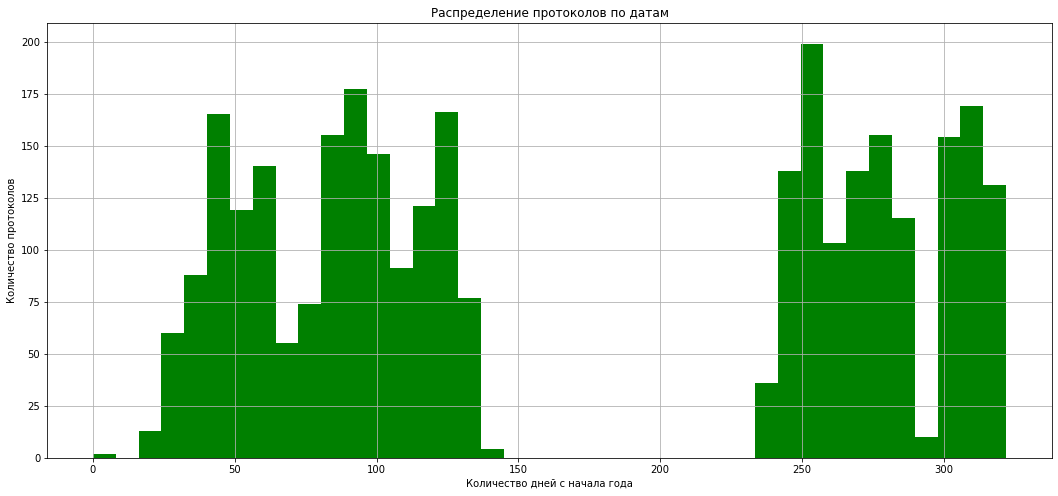

In [7]:
#df_time[df_time['days']<200].hist(bins=40, color='r')
#df_time[df_time['days']>200].hist(bins=40, color='g')
df_time['days'].hist(bins=40, color='g')

plt.title("Распределение протоколов по датам")
plt.xlabel('Количество дней с начала года')
plt.ylabel('Количество протоколов')

In [8]:
# Посчитаем минимальную дату для осеннего периода
fall_min = df_time[df_time['days']>200]['days'].min()
fall_min

234

In [9]:
# Добавим колонки "Количество дней с начала текущего периода" и "Период"

df_time['period'] = df_time.apply(lambda x: 1 if x['days']<fall_min else 2, axis=1) 
df_time['day_of_period'] = df_time.apply(lambda x: x['days'] if x['days']<fall_min else x['days']-fall_min, axis=1) 

df_time[['period','days','day_of_period']].head(-10)

,period,days,day_of_period
0,1,18,18
1,1,19,19
2,1,19,19
3,1,21,21
4,1,24,24
...,...,...,...
2986,2,315,81
2987,2,318,84
2988,2,318,84
2989,2,318,84


In [10]:
# Для формирования колонки interval, в которой для каждого протокола нужно фиксировать, 
# сколько дней прошло до текущего урока текущего учителя со дня предыдущего урока,
# создадим словарь словарей, в котором ключами первого словаря будут id учителей, 
# ключами вложенных словарей - id протоколов, а значениями - интервалы для текущего протокола)

teachers_prots = {}
teachers = df_time['teacher_id'].unique().tolist()
for teacher in teachers:
    t_df_spring = df_time[((df_time['teacher_id']==teacher) & (df_time['period']==1))][['prot_id', 'day_of_period']].sort_values(by='day_of_period')
    t_df_spring['interval'] = t_df_spring['day_of_period'] - t_df_spring['day_of_period'].shift(1)
    t_df_fall = df_time[((df_time['teacher_id']==teacher) & (df_time['period']==2))][['prot_id', 'day_of_period']].sort_values(by='day_of_period')
    t_df_fall['interval'] = t_df_fall['day_of_period'] - t_df_fall['day_of_period'].shift(1)
   
    teachers_prots[teacher] = {row['prot_id']: row['interval'] for row in t_df_spring.append(t_df_fall).to_dict('records')}
#print(teachers_prots[726][815])
#print(teachers_prots)

In [11]:
# Добавим эту колонку
df_time['interval'] = df_time.apply(lambda x: teachers_prots[x['teacher_id']][x['prot_id']], axis=1) 
df_time.head(2)

,prot_id,template_code,date_of_lesson,org_id,teacher_id,observer_id,curator_id,class,satisfaction,wish_to_change,...,interactions_weak,attention_all,attention_strong,attention_middle,attention_weak,teacher_comments,days,period,day_of_period,interval
0,816,П1.1,01.02.2022,133,726,725,724,NaN,NaN,NaN,...,NaN,10.0,NaN,NaN,NaN,Больше внимания уделять слабым ученикам и моти...,18,1,18,NaN
1,1162,П1.1,02.02.2022,128,736,735,734,NaN,NaN,NaN,...,NaN,6.0,NaN,NaN,NaN,Учитель уделяет внимание всем учащимся,19,1,19,NaN


#### Посмотрим сразу же статистические распределения по этому параметру для весны и осени
- Вначале - Боксплоты
- Потом - отдельно гистограммы по весне и по осени

<AxesSubplot:title={'center':'Дни заполнения протоколов по периодам (1 - весна, 2 - осень)'}, xlabel='period', ylabel='interval'>

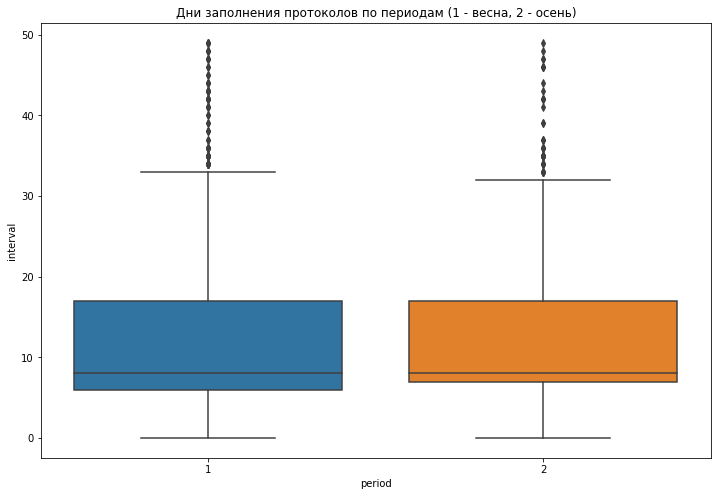

In [12]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.title('Дни заполнения протоколов по периодам (1 - весна, 2 - осень)')

sns.boxplot(y=df_time[df_time['interval']<50]['interval'], x=df_time['period']) 

Text(0.5, 1.0, 'Интервалы между уроками весной')

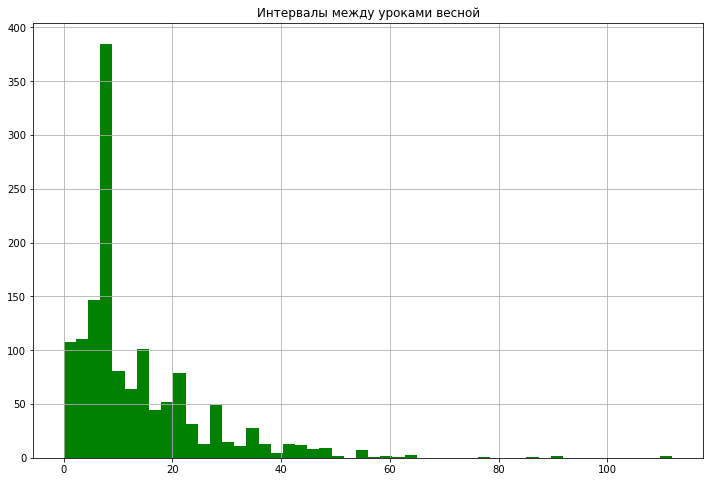

In [13]:
df_time[df_time['period']==1]['interval'].hist(bins=50, color='green')
plt.title('Интервалы между уроками весной')

Text(0.5, 1.0, 'Интервалы между уроками осенью')

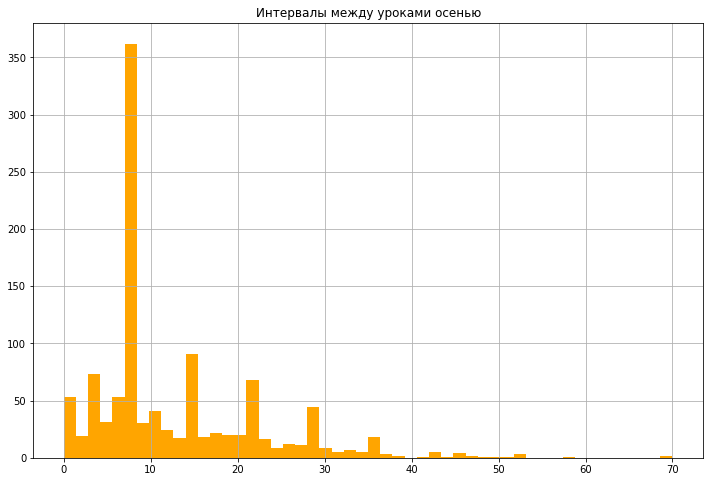

In [14]:
df_time[df_time['period']==2]['interval'].hist(bins=50, color='orange')
plt.title('Интервалы между уроками осенью')

### Краткое резюме по вторичным колонкам, связанным со временем (по всем протоколам)
- распределения по времени проведения уроков неравномерны по месяцам. Это может быть связано с особенностями организации учебной программы и периодами сдачи промежуточных отчетов. Кроме того, на возможность проведения уроков с присутствием на уроке коллеги, играющего роль наблюдателя, могут быть ограничены в случае, если у школы возникают какие-либо повышенные нагрузки, из-за которых учителя не имеют времени для посещений уроков. Такие периоды могут совпадать в разных школах одного и того же региона, если нагрузка "провоцируется", к примеру, вышестоящим начальством. Конечно, возможны "провалы" в графиках из-за школьных каникул. Если учеников нет в школе, то и уроки не проводятся.
- Интервалы между уроками очень разные, и этот параметр будет более интересным посмотреть на уровне отдельных учителей (средние показатели и дисперсии). Однако бросаются в глаза периодические пики, кратные 7 дням. Очевидно, что многие учителя в рамках проекта установили для себя определенные дни недели для проведения протоколирования своих уроков и пытались следовать этому расписанию. Видимо, это практиковалось некоторыми учителями в том числе для того, чтобы проводить уроки только в одном из своих классов, чтобы появилась возможность фиксировать динамику изменений в этом классе.


### Добавляем колонки по группам учеников
1. Добавим колонку **scope** (отношение количества учеников, с которыми взаимодействовал учитель, к общему количеству учеников на уроке. nan если поля pupils_all или attention_all нулевые или равны nan, и attention_all/pupils_all в противном случае)
2. Добавим колонку **pupils_m** (матожидание среднего уровня учеников на уроке. Число от 0 до 1)
3. Добавим колонку **pupils_d** (дисперсия уровня учеников на уроке. Число от 0 до 1)
4. Добавим колонку **interactions_m**
5. Добавим колонку **interactions_d**
6. Добавим колонку **attention_m**
7. Добавим колонку **attention_d**
8. Добавим колонку **vector_interact** (Вектор взаимодействия - разница между pupils_m и interactions_m)
9. Добавим колонку **vector_intention** (Вектор намерения - разница между pupils_m и attention_m)
10. Добавим колонку **vector_attention** (Вектор внимания - разница между attention_m и interactions_m)

In [15]:
# Создадим копию текущего датасета, чтобы можно было при отладке кода начинать не с начала, а с этой ячейки
df_levels = df_time.copy()

In [16]:
#Проверяем, есть ли протоколы с некорректными данными 
# (количество учеников, с которыми взаимодействовал учитель, больше, чем количество учеников на уроке)
# Наличие таких записей будет говорить о невалидности данных таких протоколов. 
df_levels[(df_levels['attention_all']>df_levels['pupils_all'])][['prot_id', 'pupils_all', 'attention_all']]

,prot_id,pupils_all,attention_all
132,314,16.0,21.0
188,296,11.0,20.0
191,210,9.0,23.0
195,205,9.0,23.0
551,1657,9.0,10.0
789,2958,7.0,102.0
796,2997,26.0,48.0
799,598,11.0,37.0
872,1690,2.0,6.0
1010,2820,7.0,11.0


In [18]:
df_levels['attention_all'].describe()

count    2643.000000
mean        9.494892
std         6.573830
min         1.000000
25%         5.000000
50%         8.000000
75%        12.000000
max       102.000000
Name: attention_all, dtype: float64

In [19]:
# Добавляем колонку scope
df_levels['scope'] = df_levels.apply(lambda x: x['attention_all']/x['pupils_all'] 
                                     if ((x['attention_all'] <= x['pupils_all']) & (x['pupils_all']>0) & (x['attention_all']>0))  
                                     else np.nan, axis=1)
df_levels['scope'].describe()

count    2600.000000
mean        0.907798
std         0.161486
min         0.187500
25%         0.857143
50%         1.000000
75%         1.000000
max         1.000000
Name: scope, dtype: float64

Text(0.5, 1.0, 'Доля учеников на уроке, с которыми взаимодействует учитель')

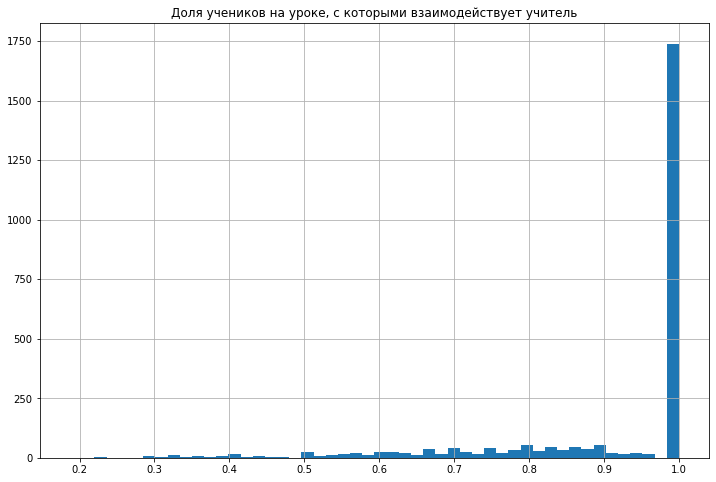

In [20]:
df_levels['scope'].hist(bins=50)
plt.title('Доля учеников на уроке, с которыми взаимодействует учитель')

___
<a id='analysis2' name='analysis2'></a>
## 10. Еще один взгляд на данные

1. Добавим колонки с